<a href="https://colab.research.google.com/github/ngcheeyuan/Tensorflow-Certification-Practice/blob/main/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q Pillow

In [ ]:
import os
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data gathering

In [ ]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
TRAIN_DIR = "./cats_and_dogs_filtered/train"
VAL_DIR = "./cats_and_dogs_filtered/validation"

Inspect samples from datasets.

Image shape: (360, 499, 3)
Pixel in range: 0 255


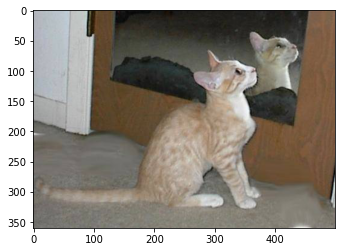

In [ ]:
sample_idx = 0
label = "cats"
train_sample_fn = os.listdir(os.path.join(TRAIN_DIR, label))[sample_idx]
train_sample_path = os.path.join(TRAIN_DIR, label, train_sample_fn)

img = Image.open(train_sample_path)
img_data = np.asarray(img)

print("Image shape:", img_data.shape)
print("Pixel in range:", np.min(img_data), np.max(img_data))
plt.imshow(img_data);

**Create TF datasets** (with data augmentation in training)

In [ ]:
import pandas as pd
def plot_loss(history):
  df = pd.DataFrame(history.history)
  df['epochs'] = range(0,len(df))
  plt.figure(figsize = (10,7))
  plt.subplot(1,2,1)
  plt.plot(df['epochs'],df['accuracy'] , label = 'train accuracy')
  plt.plot(df['epochs'],df['val_accuracy'], label = 'val accuracy')
  plt.title('Model Accuracy')
  plt.subplot(1,2,2)
  plt.plot(df['epochs'],df['loss'] , label = 'train loss')
  plt.plot(df['epochs'],df['val_loss'], label = 'val loss')
  plt.title('Model Loss')
  plt.legend()

In [ ]:
IMG_SIZE = (224, 224)
INP_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 32

def gen_new_data(data_folder, augmented=True):
  if augmented:
    data_gen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
  else:
    data_gen = ImageDataGenerator(rescale=1./255)

  data = data_gen.flow_from_directory(
      data_folder,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode="binary",
  )
  return data

In [ ]:
ds_train = gen_new_data(TRAIN_DIR, augmented=True)
ds_val = gen_new_data(VAL_DIR, augmented=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model 0 : Tiny VGG block

Reference : https://arxiv.org/abs/1409.1556

In [ ]:
FILTERS = 10

model_0 = tf.keras.Sequential([
                             layers.Conv2D(FILTERS,(3,3), activation = 'relu', name = 'conv_1_1'),
                             layers.Conv2D(FILTERS,(3,3), activation = 'relu', name = 'conv_1_2'),
                             layers.MaxPool2D((2,2), name = 'max_pool_1'),
                             layers.Conv2D(FILTERS,(3,3), activation = 'relu', name = 'conv_2_1'),
                             layers.Conv2D(FILTERS,(3,3), activation = 'relu', name = 'conv_2_2'),
                             layers.MaxPool2D((2,2), name = 'max_pool_2'),
                             layers.Flatten(),
                             layers.Dense(1 , activation = 'sigmoid')
])

In [ ]:
model_0.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy'],
                optimizer = tf.keras.optimizers.Adam())

In [73]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_1 (Conv2D)           (None, None, None, 10)    280       
                                                                 
 conv_1_2 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, None, None, 10)    0         
                                                                 
 conv_2_1 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 conv_2_2 (Conv2D)           (None, None, None, 10)    910       
                                                                 
 max_pool_2 (MaxPooling2D)   (None, None, None, 10)    0         
                                                                 
 flatten (Flatten)           (None, None)              0

In [ ]:
FILE_PATH = 'model_checkpoints'

history_model_0 = model_0.fit(ds_train,
                              epochs = 20,
                              validation_data = ds_val,
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                            patience = 5,
                                                                            min_delta = 0.001,
                                                                            restore_best_weights = True
                                                                            ),
                                          tf.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
                                                                              filepath = FILE_PATH,
                                                                              save_best_only = True
                                          )]
                              )

Epoch 1/20
63/63 [==============================] - 47s 678ms/step - loss: 0.6941 - accuracy: 0.5135 - val_loss: 0.6925 - val_accuracy: 0.5700
Epoch 2/20
63/63 [==============================] - 33s 523ms/step - loss: 0.6921 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
63/63 [==============================] - 35s 561ms/step - loss: 0.6930 - accuracy: 0.4930 - val_loss: 0.6920 - val_accuracy: 0.4940
Epoch 4/20
63/63 [==============================] - 33s 517ms/step - loss: 0.6913 - accuracy: 0.5010 - val_loss: 0.6903 - val_accuracy: 0.5090
Epoch 5/20
63/63 [==============================] - 34s 538ms/step - loss: 0.6901 - accuracy: 0.5525 - val_loss: 0.6887 - val_accuracy: 0.5720
Epoch 6/20
63/63 [==============================] - 43s 682ms/step - loss: 0.6867 - accuracy: 0.5470 - val_loss: 0.6719 - val_accuracy: 0.6280
Epoch 7/20
63/63 [==============================] - 33s 523ms/step - loss: 0.6833 - accuracy: 0.5665 - val_loss: 0.6760 - val_accuracy: 0.5980

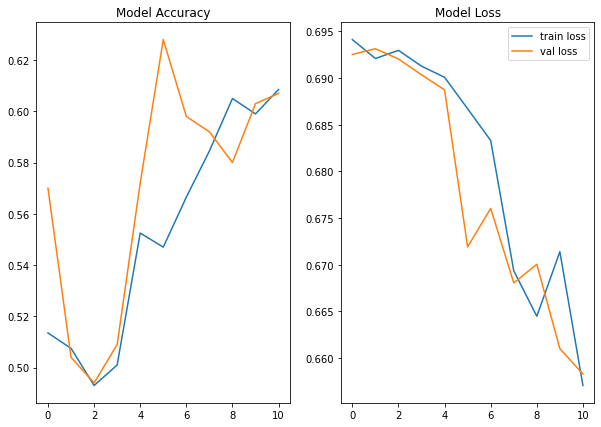

In [ ]:
plot_loss(history_model_0)

In [ ]:
model_0 = tf.keras.models.load_model(FILE_PATH)

In [ ]:
model_0.evaluate(ds_val)

32/32 [==============================] - 6s 178ms/step - loss: 0.6719 - accuracy: 0.6280


[0.6719174385070801, 0.628000020980835]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import tensorflow_hub as hub

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4" 

resnet = Sequential()
resnet.add(Resizing(224, 224, input_shape=(224,224,3)))
resnet.add(hub.KerasLayer(resnet_url, trainable=False))
resnet.add(Dense(1, activation="sigmoid"))

In [ ]:
resnet.compile(loss = tf.keras.losses.BinaryCrossentropy(),
               metrics = ['accuracy'],
               optimizer = tf.keras.optimizers.Adam())

In [ ]:
FILE_PATH = 'model_checkpoints'
history_resnet = resnet.fit(ds_train,
                            epochs = 20,
                            validation_data = ds_val,
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                          patience = 5,
                                                                          min_delta = 0.001,
                                                                          restore_best_weights = True
                                                                          ),
                                        tf.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
                                                                            filepath = FILE_PATH,
                                                                            save_best_only = True
                                        )]
                            )

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9335INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 457s 7s/step - loss: 0.1841 - accuracy: 0.9335 - val_loss: 0.0586 - val_accuracy: 0.9860
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9695INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 447s 7s/step - loss: 0.0847 - accuracy: 0.9695 - val_loss: 0.0442 - val_accuracy: 0.9890
Epoch 3/20
63/63 [==============================] - 435s 7s/step - loss: 0.0650 - accuracy: 0.9760 - val_loss: 0.0433 - val_accuracy: 0.9880
Epoch 4/20
63/63 [==============================] - 432s 7s/step - loss: 0.0643 - accuracy: 0.9795 - val_loss: 0.0345 - val_accuracy: 0.9890
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9835INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 446s 7s/step - loss: 0.0523 - accuracy: 0.9835 - val_loss: 0.0365 - val_accuracy: 0.9900
Epoch 6/20
63/63 [==============================] - 428s 7s/step - loss: 0.0468 - accuracy: 0.9825 - val_loss: 0.0274 - val_accuracy: 0.9900
Epoch 7/20
63/63 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9805INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 442s 7s/step - loss: 0.0496 - accuracy: 0.9805 - val_loss: 0.0288 - val_accuracy: 0.9910
Epoch 8/20
63/63 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9830INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 430s 7s/step - loss: 0.0427 - accuracy: 0.9830 - val_loss: 0.0287 - val_accuracy: 0.9920
Epoch 9/20
63/63 [==============================] - 423s 7s/step - loss: 0.0470 - accuracy: 0.9810 - val_loss: 0.0292 - val_accuracy: 0.9900
Epoch 10/20
63/63 [==============================] - 422s 7s/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.0264 - val_accuracy: 0.9920
Epoch 11/20
63/63 [==============================] - 421s 7s/step - loss: 0.0392 - accuracy: 0.9860 - val_loss: 0.0250 - val_accuracy: 0.9920
Epoch 12/20
63/63 [==============================] - 420s 7s/step - loss: 0.0366 - accuracy: 0.9870 - val_loss: 0.0352 - val_accuracy: 0.9910


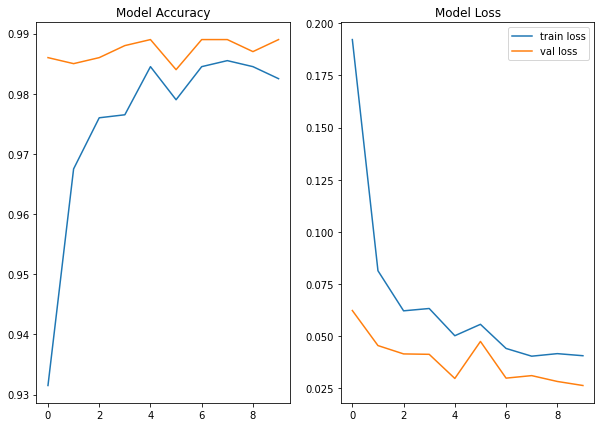

In [ ]:
plot_loss(history_resnet)

## Model 2 : Efficient Net - transfer learning

In [ ]:
efnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b7/classification/1'

efnet = Sequential()
efnet.add(Resizing(224, 224, input_shape=(224,224,3)))
efnet.add(hub.KerasLayer(efnet_url, trainable=False))
efnet.add(Dense(1, activation="sigmoid"))

In [ ]:
efnet.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'],
              optimizer = tf.keras.optimizers.Adam())

In [ ]:
history_efnet = efnet.fit(ds_train,
                          epochs = 20,
                          validation_data = ds_val,
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                          patience = 5,
                                                                          min_delta = 0.001,
                                                                          restore_best_weights = True
                                                                          ),
                                        tf.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
                                                                            filepath = FILE_PATH,
                                                                            save_best_only = True
                                        )]     
                          )

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5555INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 207s 3s/step - loss: 0.6905 - accuracy: 0.5555 - val_loss: 0.6814 - val_accuracy: 0.8120
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.8890INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 180s 3s/step - loss: 0.6748 - accuracy: 0.8890 - val_loss: 0.6654 - val_accuracy: 0.9460
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.9510INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 200s 3s/step - loss: 0.6599 - accuracy: 0.9510 - val_loss: 0.6501 - val_accuracy: 0.9630
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.9610INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 163s 3s/step - loss: 0.6453 - accuracy: 0.9610 - val_loss: 0.6352 - val_accuracy: 0.9680
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.9635INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 162s 3s/step - loss: 0.6315 - accuracy: 0.9635 - val_loss: 0.6208 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 90s 1s/step - loss: 0.6181 - accuracy: 0.9645 - val_loss: 0.6067 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 90s 1s/step - loss: 0.6047 - accuracy: 0.9645 - val_loss: 0.5932 - val_accuracy: 0.9720
Epoch 8/20
63/63 [==============================] - 90s 1s/step - loss: 0.5919 - accuracy: 0.9710 - val_loss: 0.5799 - val_accuracy: 0.9730
Epoch 9/20
63/63 [==============================] - 90s 1s/step - loss: 0.5788 - accuracy: 0.9690 - val_loss: 0.5670 - val_accuracy: 0.9730
Epoch 10/20
63/63 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.9685INFO:tensorflow:Assets written to: model_checkpoints/assets


INFO:tensorflow:Assets written to: model_checkpoints/assets


63/63 [==============================] - 161s 3s/step - loss: 0.5674 - accuracy: 0.9685 - val_loss: 0.5544 - val_accuracy: 0.9740


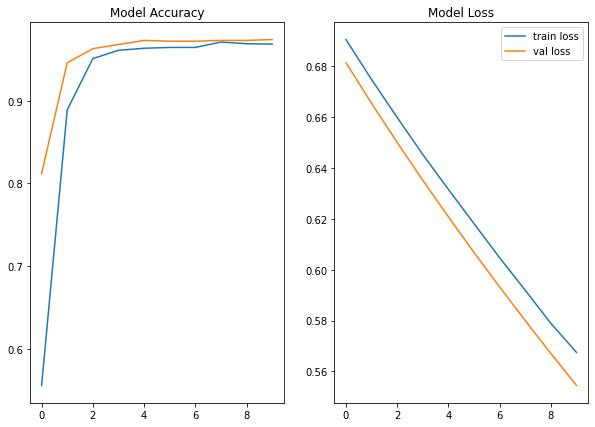

In [46]:
plot_loss(history_efnet)

## Model_3 : Fine-tuning ResNet 50 , Big Transfer 

Reference 

https://keras.io/examples/vision/bit/ 

https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb#scrollTo=qJmqsAFmeQZd

In [60]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [74]:
for layer in model.layers:
  print(layer.name , layer.trainable)

dense_5 True
keras_layer_4 False


In [61]:
NUM_CLASSES = 2 

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [63]:
# Define optimiser and loss
SCHEDULE_BOUNDARIES = [200,300,400]

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [65]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    ds_train,
    batch_size=BATCH_SIZE,
    epochs= 10,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data= ds_val        # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/10
63/63 [==============================] - 81s 1s/step - loss: 0.0932 - accuracy: 0.9505 - val_loss: 0.0183 - val_accuracy: 0.9940
Epoch 2/10
63/63 [==============================] - 62s 979ms/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0148 - val_accuracy: 0.9940
Epoch 3/10
63/63 [==============================] - 62s 990ms/step - loss: 0.0414 - accuracy: 0.9845 - val_loss: 0.0154 - val_accuracy: 0.9950
Epoch 4/10
63/63 [==============================] - 62s 989ms/step - loss: 0.0391 - accuracy: 0.9840 - val_loss: 0.0198 - val_accuracy: 0.9940
Epoch 5/10
63/63 [==============================] - 62s 988ms/step - loss: 0.0286 - accuracy: 0.9895 - val_loss: 0.0179 - val_accuracy: 0.9940
Epoch 6/10
63/63 [==============================] - 62s 985ms/step - loss: 0.0263 - accuracy: 0.9905 - val_loss: 0.0179 - val_accuracy: 0.9940
Epoch 7/10
63/63 [==============================] - 62s 988ms/step - loss: 0.0325 - accuracy: 0.9890 - val_loss: 0.0179 - val_accuracy: 0.9940
Ep

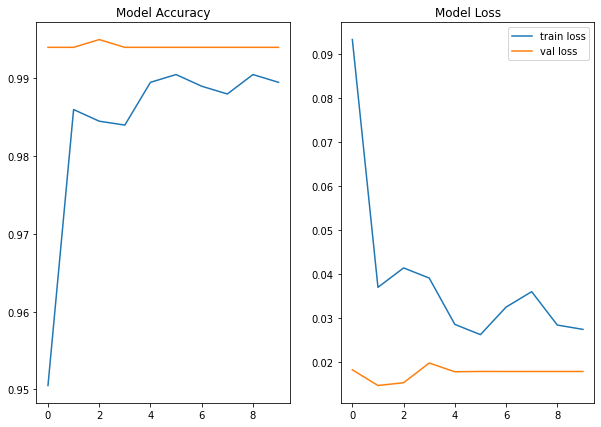

In [75]:
plot_loss(history)